In [1]:
import os
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

## Download dataset 
https://drive.google.com/drive/folders/1vI8Bkk5DojitLNkpz-UT30jOEay0XXon?usp=sharing

In [2]:
# parameters
BATCH_SIZE = 16
mini_batch = 500
num_workers = 2
gpu_idx = 1
# 'simple_net', 'resnet', 'wide_resnet', 'efficientnet'
model_use = 'efficientnet'
EPOCH = 40
PATH = './cifar_efficientnet_ep40.pth'

## Load data

In [3]:
x_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")

x_test = np.load("x_test.npy")
y_test = np.load("y_test.npy")

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

50000 train samples
10000 test samples


In [4]:
# It's a multi-class classification problem 
class_index = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat',4: 'deer',
               5: 'dog',6: 'frog',7: 'horse',8: 'ship',9: 'truck'}
print(np.unique(y_train))

[0 1 2 3 4 5 6 7 8 9]


![image](https://img-blog.csdnimg.cn/20190623084800880.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3lqcDE5ODcxMDEz,size_16,color_FFFFFF,t_70)

## Data preprocess

In [5]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

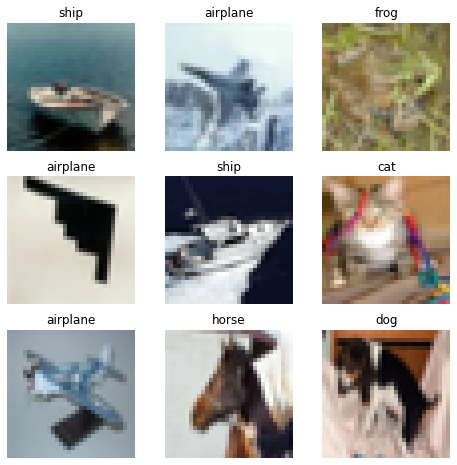

In [6]:
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(x_train), size=(1,)).item()
    img = x_train[sample_idx]
    label = y_train[sample_idx]
    figure.add_subplot(rows, cols, i)
    
    plt.title(class_index[int(label)])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Dataset

In [7]:
from torch.utils.data import TensorDataset, DataLoader

tensor_x_train = torch.Tensor(x_train).permute(0, 3, 1, 2) # transform to torch tensor
tensor_y_train = torch.Tensor(y_train).squeeze()
tensor_x_test = torch.Tensor(x_test).permute(0, 3, 1, 2)
tensor_y_test = torch.Tensor(y_test).squeeze()

training_data = TensorDataset(tensor_x_train, tensor_y_train)
test_data = TensorDataset(tensor_x_test, tensor_y_test)

trainloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)
testloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)

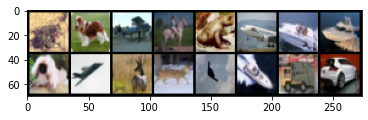

frog  dog   airplane horse frog  airplane ship  ship  dog   airplane deer  deer  airplane ship  truck automobile


In [8]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
#print(labels)
# print labels
print(' '.join(f'{class_index[int(labels[j])]:5s}' for j in range(BATCH_SIZE)))

In [9]:
torch.cuda.is_available()

True

In [10]:
device = torch.device("cuda:"+str(gpu_idx) if torch.cuda.is_available() else "cpu")
print(device)

cuda:1


In [11]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


if model_use == 'simple_net':
    net = Net()
    print(net)
elif model_use == 'resnet':
    # resnet
    net = models.resnet18(pretrained=True)
    print(net)
    num_ftrs = net.fc.in_features
    net.fc = nn.Linear(num_ftrs, 10)
elif model_use == 'wide_resnet':
    net = models.wide_resnet50_2(pretrained=True)
    print(net)
    num_ftrs = net.fc.in_features
    net.fc = nn.Linear(num_ftrs, 10)
elif model_use == 'efficientnet':
    net = models.efficientnet_b7(pretrained=True)
    print(net)
    num_ftrs = net.classifier[1].in_features
    net.fc = nn.Linear(num_ftrs, 10)
else:
    raise Exception('wrong model name')


EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivatio

In [12]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)

In [13]:
net = net.to(device)

## Training

In [14]:
from tqdm.notebook import tqdm
import logging

logging.basicConfig(level=logging.INFO, filename='log.txt', filemode='a',
	format='[%(asctime)s %(levelname)-8s] %(message)s',
	datefmt='%Y%m%d %H:%M:%S',
	)

net.train()
for epoch in range(EPOCH):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in tqdm(enumerate(trainloader, 0)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device=device)
        labels = labels.to(device=device, dtype=torch.int64)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % mini_batch == (mini_batch - 1):
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / mini_batch:.3f}')
            logging.info(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / mini_batch:.3f}')
            running_loss = 0.0

print('Finished Training')

0it [00:00, ?it/s]

[1,   500] loss: 7.733
[1,  1000] loss: 4.594
[1,  1500] loss: 3.052
[1,  2000] loss: 2.651
[1,  2500] loss: 2.422
[1,  3000] loss: 2.275


0it [00:00, ?it/s]

[2,   500] loss: 2.190
[2,  1000] loss: 2.111
[2,  1500] loss: 2.056
[2,  2000] loss: 1.993
[2,  2500] loss: 1.960
[2,  3000] loss: 1.922


0it [00:00, ?it/s]

[3,   500] loss: 1.882
[3,  1000] loss: 1.847
[3,  1500] loss: 1.799
[3,  2000] loss: 1.752
[3,  2500] loss: 1.741
[3,  3000] loss: 1.711


0it [00:00, ?it/s]

[4,   500] loss: 1.662
[4,  1000] loss: 1.650
[4,  1500] loss: 1.658
[4,  2000] loss: 1.616
[4,  2500] loss: 1.595
[4,  3000] loss: 1.597


0it [00:00, ?it/s]

[5,   500] loss: 1.574
[5,  1000] loss: 1.576
[5,  1500] loss: 1.566
[5,  2000] loss: 1.548
[5,  2500] loss: 1.540
[5,  3000] loss: 1.503


0it [00:00, ?it/s]

[6,   500] loss: 1.462
[6,  1000] loss: 1.454
[6,  1500] loss: 1.442
[6,  2000] loss: 1.446
[6,  2500] loss: 1.413


In [ ]:
torch.save(net.state_dict(), PATH)

## End Training

In [ ]:
net.eval()
net.load_state_dict(torch.load(PATH))

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device=device)
        labels = labels.to(device=device, dtype=torch.int64)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')
logging.info(f'{PATH}: Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 73 %


In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in list(class_index.keys())}
total_pred = {classname: 0 for classname in list(class_index.keys())}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device=device)
        labels = labels.to(device=device, dtype=torch.int64)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[int(label)] += 1
            total_pred[int(label)] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {class_index[classname]:5s} is {accuracy:.1f} %')



Accuracy for class: airplane is 79.5 %
Accuracy for class: automobile is 82.2 %
Accuracy for class: bird  is 68.8 %
Accuracy for class: cat   is 56.2 %
Accuracy for class: deer  is 67.6 %
Accuracy for class: dog   is 65.1 %
Accuracy for class: frog  is 78.7 %
Accuracy for class: horse is 77.0 %
Accuracy for class: ship  is 83.5 %
Accuracy for class: truck is 80.5 %


Ref: <br>
https://pytorch.org/tutorials/beginner/basics/data_tutorial.html <br>
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html <br>

## DO NOT MODIFY CODE BELOW!
**Please screen shot your results and post it on your report**

In [ ]:
y_pred = your_model.predict(x_test)

NameError: name 'your_model' is not defined

In [ ]:
assert y_pred.shape == (10000,)

In [ ]:
y_test = np.load("y_test.npy")
print("Accuracy of my model on test set: ", accuracy_score(y_test, y_pred))